In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import sympy as sym
import warnings
import pickle as plk
from IPython.display import display, Math
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks

import os
import imp
import sys
import importlib.util

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Optical_Hybrid/SimulationFiles')) #Current directory

###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Optical_Hybrid/SimulationFiles/'))
# spec_win.loader.exec_module(lumapi)

###############################################################
# TERMINAL FILE PATH
# /opt/lumerical/v221/bin/fdtd-engine-mpich2nem /home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Optical_Hybrid/SimulationFiles/MMIHybrid.fsp -t 8
# /opt/lumerical/v221/bin/fdtd-engine-mpich2nem /home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Optical_Hybrid/SimulationFiles/MMIHybrid_s-parametersweep/s-parametersweep_1.fsp -t 8



/tmp/ipykernel_173906/1930891817.py:13: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
hyb = lumapi.FDTD(filename='YBranchHybrid.fsp',hide=False) 

## Functions

In [9]:
# Search for function's intersections on signal levels
def signalLv(yarray,level,type):
    peak, pd = find_peaks(yarray)
    maxpeak = yarray[peak[np.argmax(yarray[peak])]]
    minpeak = yarray[np.argmin(yarray)]
    index = []

    if(type == 'linear'):
        lvpeak = (maxpeak - minpeak)*level + minpeak
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = (yarray[index[0]] + yarray[index[-1]])/2

    if(type == 'log10'):
        lvpeak = maxpeak + 10*np.log10(level)
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = 10*np.log10((10**(yarray[index[0]]/2) + 10**(yarray[index[1]]/2))/2)

    return {'index':index,'yMed':yMed}


# Creates a box
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })


# Format a function/dataset as a polygon
def PolyForm(x,y,ybase):
    y2 = y + ybase
    A = np.zeros((2,len(x)+2))
    
    A[0][1:len(x)+1] = x
    A[1][1:len(x)+1] = y2
    A[0][0] = x[0]
    A[0][len(x)+1] = x[-1]
    A[1][0] = ybase
    A[1][len(x)+1] = ybase
    
    return A

## Assembly parameters

In [21]:
Material = "Si (Silicon) - Palik"

B90Radius = 4e-6

simTime = 1500e-15
FDTDAccuracy = 4

In [65]:
hyb.switchtolayout()
hyb.deleteall()

# Creating the Full Body
Verts = np.array([[-1e-6, 0.5e-6/2], [-0.833e-6, 0.5e-6/2], [-0.666e-6, 0.6e-6/2],
                  [-0.499e-6, 0.7e-6/2], [-0.332e-6, 0.9e-6/2], [-0.165e-6, 1.26e-6/2],
                  [0.002e-6, 1.4e-6/2], [0.169e-6, 1.4e-6/2], [0.336e-6, 1.4e-6/2],
                  [0.503e-6, 1.4e-6/2], [0.67e-6, 1.31e-6/2], [0.837e-6, 1.2e-6/2],
                  [1e-6, 1.2e-6/2],
                  
                  [1e-6, -1.2e-6/2], [0.837e-6, -1.2e-6/2], [0.67e-6, -1.31e-6/2],
                  [0.503e-6, -1.4e-6/2], [0.336e-6, -1.4e-6/2], [0.169e-6, -1.4e-6/2],
                  [0.002e-6, -1.4e-6/2], [-0.165e-6, -1.26e-6/2], [-0.332e-6, -0.9e-6/2],
                  [-0.499e-6, -0.7e-6/2], [-0.666e-6, -0.6e-6/2], [-0.833e-6, -0.5e-6/2],
                  [-1e-6, -0.5e-6/2]])   # Vertices

hyb.addpoly()
hyb.set("name", "FullBody")
hyb.set("vertices",Verts)
hyb.set({"x":0, "y":0, "z":0, "z span":220e-9,
        "material":Material})


# Creating bends and post-bends
RectInsert(-1.5e-6,1e-6,0,0.5e-6,0,220e-9,Material,hyb)
RectInsert(B90Radius+1e-6,0.5e-6,B90Radius+0.6e-6,0.5e-6,0,220e-9,Material,hyb)
hyb.set("name", "Post-bend 1")
RectInsert(B90Radius+1e-6,0.5e-6,-B90Radius-0.6e-6,0.5e-6,0,220e-9,Material,hyb)
hyb.set("name", "Post-bend 2")

GenPar = {"base angle":90, "base height":0.22e-6, "base width":0.5e-6,
                 "radius":B90Radius, "material":Material}    # General parameter sets

hyb.addobject('90_bend_wg')
hyb.set(GenPar)
hyb.set({"start angle":270, "name":"Output bend 1",
        "x":1e-6, "y":B90Radius + 0.35e-6, "z":0})

hyb.addobject('90_bend_wg')
hyb.set(GenPar)
hyb.set({"start angle":0, "name":"Output bend 2",
        "x":1e-6, "y":- B90Radius - 0.35e-6, "z":0})


# FDTD Setting
hyb.addfdtd()
hyb.set({"x":(1e-6+B90Radius)/2, "y":0, "z":0,
         "z span":3e-6,
         "simulation time":simTime, "mesh accuracy":FDTDAccuracy,
         "z min bc":"Symmetric"})
hyb.set({"x span":5e-6+B90Radius, "y span": 1.5e-6 + 2*B90Radius})
hyb.set("background material","SiO2 (Glass) - Palik")


# Creating Ports
hyb.addport()
hyb.set({"x":-1.5e-6, "y":0, "z":0,
        "y span":3e-6, "z span":3e-6,
        "direction":"Forward"})

hyb.addport()
hyb.set("injection axis","y-axis")
hyb.set({"x":B90Radius+1e-6, "y": B90Radius+0.6e-6, "z":0,
        "x span":3e-6, "z span":3e-6,
        "direction":"Backward"})

hyb.addport()
hyb.set("injection axis","y-axis")
hyb.set({"x":B90Radius+1e-6, "y": -B90Radius-0.6e-6, "z":0,
        "x span":3e-6, "z span":3e-6,
        "direction":"Forward"})

# Editing source settings
hyb.select('FDTD::ports')
hyb.set('monitor frequency points',1500)
hyb.setglobalsource("wavelength start", 1500e-9)
hyb.setglobalsource("wavelength stop", 1600e-9)


# Creating monitor region
hyb.addpower()  # Planar monitor
hyb.set({"x":(1e-6+B90Radius)/2, "x span":3e-6+B90Radius, "y":0, "y span":1e-6 + 2*B90Radius})
hyb.setglobalmonitor("use source limits",0)
hyb.setglobalmonitor("minimum wavelength",1500e-9)
hyb.setglobalmonitor("maximum wavelength",1600e-9)
hyb.setglobalmonitor("frequency points",20)

{!!}

{!!}



1.0

## Mesh convergence sweep

In [66]:
# Sweep configs
SPoints = 6      # Sweep points
SRange = [2,7]  # Sweep range
Name = "Mesh_sweep"

# Sweep creation
hyb.deletesweep(Name)
hyb.addsweep(0)
hyb.setsweep("sweep","name",Name)
hyb.setsweep(Name,"type","Ranges")
hyb.setsweep(Name,"number of points",SPoints)

MeshParameter = {"Name":"Mesh accuracy", "Type":"Number",
               "Parameter":"::model::FDTD::mesh accuracy",
               "Start":SRange[0], "Stop":SRange[1]}

Transmission_In = {"Name":"Transmission In",
                   "Result":"::model::FDTD::ports::port 1::T"}
Transmission_Out1 = {"Name":"Transmission Out 1",
                     "Result":"::model::FDTD::ports::port 2::T"}
Transmission_Out2 = {"Name":"Transmission Out 2",
                     "Result":"::model::FDTD::ports::port 3::T"}

hyb.addsweepparameter(Name,MeshParameter)
hyb.addsweepresult(Name,Transmission_In)
hyb.addsweepresult(Name,Transmission_Out1)
hyb.addsweepresult(Name,Transmission_Out2)

'Transmission Cross'

dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
(1500, 5)
dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
(1500, 5)
dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
(1500, 5)


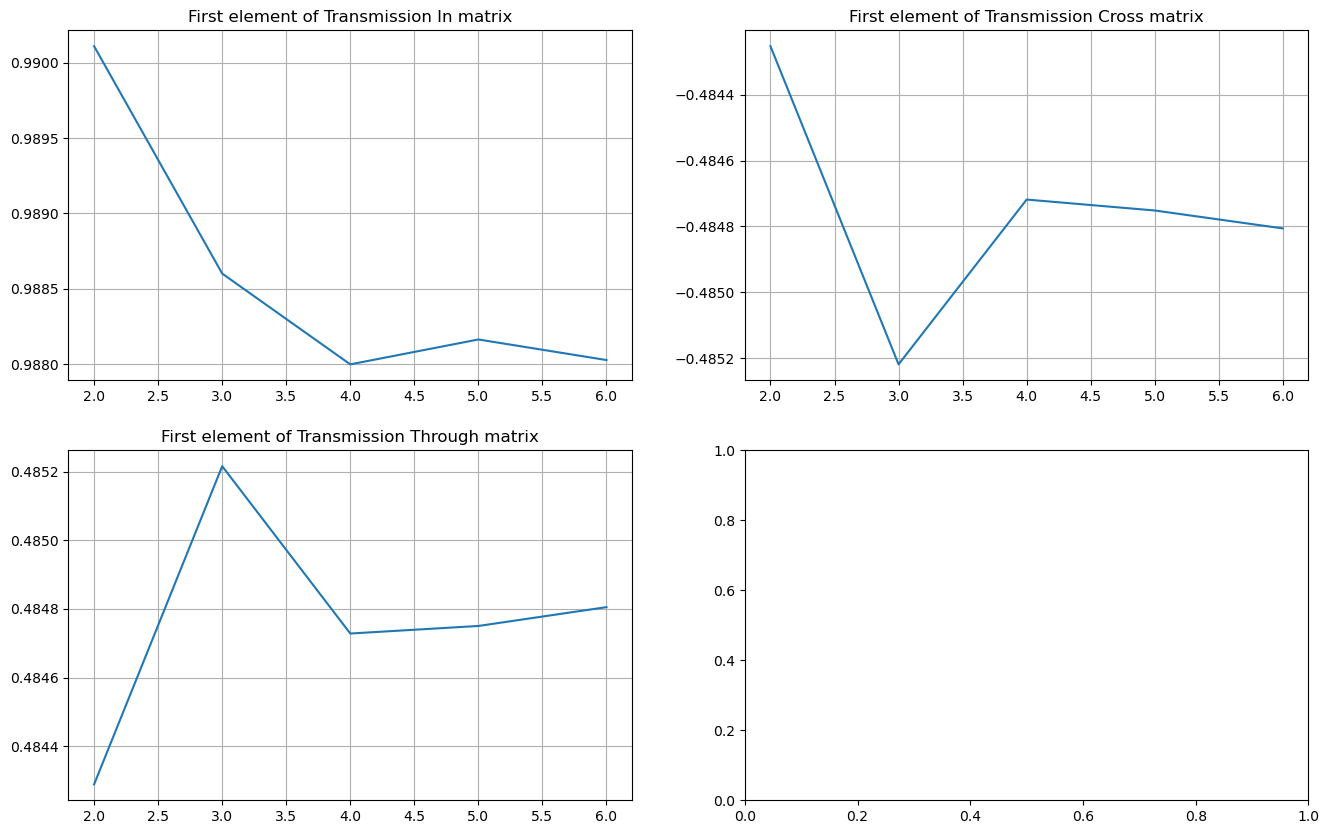

In [123]:
fig, ax = plt.subplots(2,2,figsize=(16,10))
sweepMatrix = ["Transmission In","Transmission Cross","Transmission Through"]
for j in range(3):    
    dataSet = hyb.getsweepresult("Mesh_sweep",sweepMatrix[j])
    subSet = dataSet['T']
    xSet = dataSet['Mesh accuracy']

    print(dataSet.keys())
    print(np.shape(subSet))

    TSet = []
    for i in range(len(subSet[0,:])):
        TSet.append(subSet[0,i])

    win = [int( j/2 ) , int( j%2 )] # Window plot indexes
    ax[win[0]][win[1]].plot(xSet[0,:],TSet)
    ax[win[0]][win[1]].grid(True)
    ax[win[0]][win[1]].set_title("First element of {} matrix".format(sweepMatrix[j]))

## Loadings

### Load Power Field

dict_keys(['lambda', 'f', 'x', 'y', 'z', 'P', 'Lumerical_dataset'])
(274, 378, 1, 20, 3)


Text(0.5, 1.0, 'Eletric field distribution 1551.02nm')

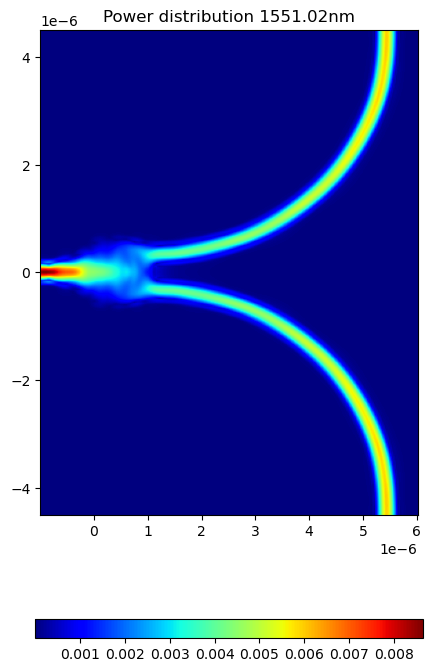

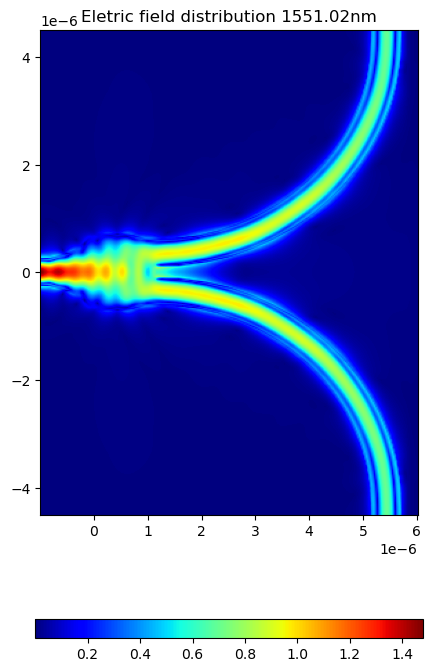

In [103]:
fIndex = 9  # Frequency index

# Power
P = hyb.getresult("monitor","P")
PwrArray = np.array(P['P'])
print(P.keys())
print(np.shape(PwrArray))

Px = PwrArray[:,:,0,fIndex,0]
Py = PwrArray[:,:,0,fIndex,1]
Pz = PwrArray[:,:,0,fIndex,2]

PAbs = np.sqrt(np.multiply(Px,Px) + np.multiply(Py,Py) + np.multiply(Py,Py))
Ax = ([ float(P['x'][0]) , float(P['x'][-1]) ])
Ay = ([ float(P['y'][0]) , float(P['y'][-1]) ])

# Plotting the color graph
plt.figure(figsize=(5,9))
ax = plt.imshow(np.abs(np.transpose(PAbs)),cmap ='jet', extent=[Ax[0],Ax[1],Ay[0],Ay[1]])
plt.colorbar(orientation='horizontal')
plt.title('Power distribution {:.2f}nm'.format(1e9*float(P['lambda'][fIndex])))


# Eletric field
E = hyb.getresult("monitor","E")
PwrArray = np.array(E['E'])

Ex = PwrArray[:,:,0,fIndex,0]
Ey = PwrArray[:,:,0,fIndex,1]
Ez = PwrArray[:,:,0,fIndex,2]

EAbs = np.sqrt(np.multiply(Ex,Ex) + np.multiply(Ey,Ey) + np.multiply(Ey,Ey))
Ax = ([ float(E['x'][0]) , float(E['x'][-1]) ])
Ay = ([ float(E['y'][0]) , float(E['y'][-1]) ])

# Plotting the color graph
plt.figure(figsize=(5,9))
ax = plt.imshow(np.abs(np.transpose(EAbs)),cmap ='jet', extent=[Ax[0],Ax[1],Ay[0],Ay[1]])
plt.colorbar(orientation='horizontal')
plt.title('Eletric field distribution {:.2f}nm'.format(1e9*float(P['lambda'][fIndex])))

### Load transmission

dict_keys(['lambda', 'f', 'T', 'Lumerical_dataset'])


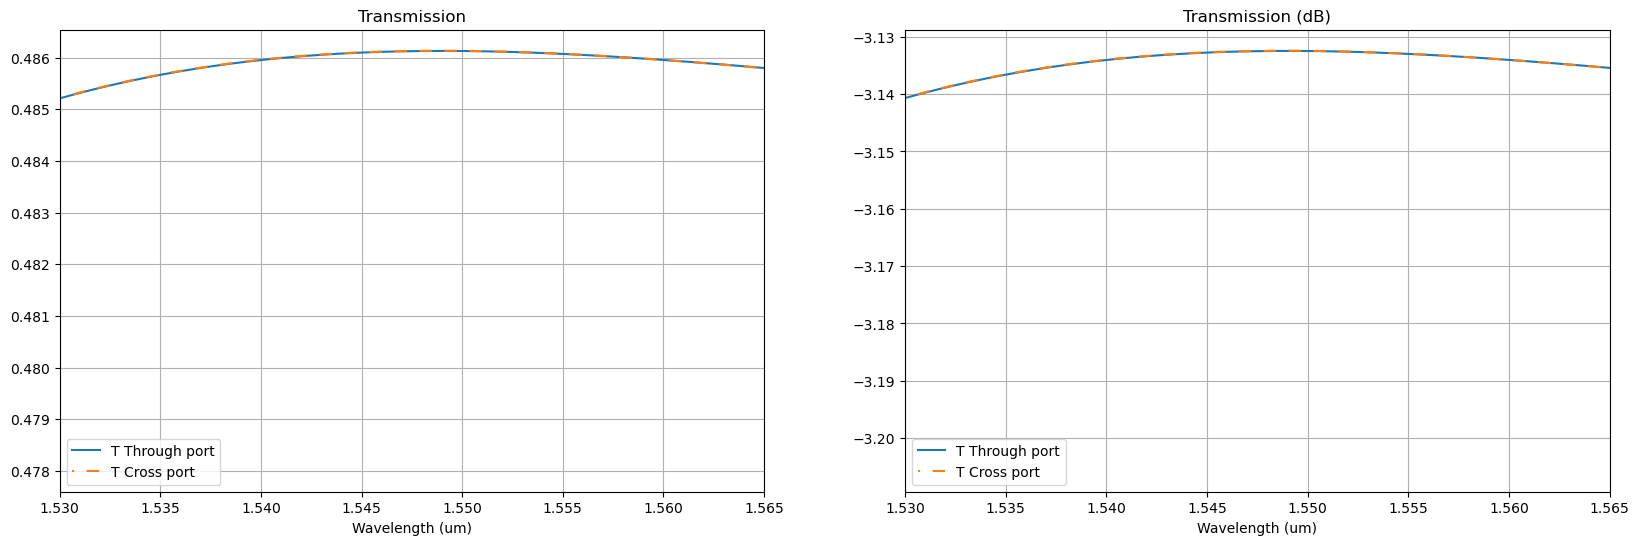

In [120]:
wavelim = [1.53, 1.565]

T3 = hyb.getresult("FDTD::ports::port 2","T")
T4 = hyb.getresult("FDTD::ports::port 3","T")

print(T3.keys())
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].plot(T3['lambda']*1e6, T3['T'], label='T Through port')
ax[0].plot(T4['lambda']*1e6, -T4['T'], label='T Cross port',linestyle=(5, (6, 6)))
ax[0].set_title('Transmission')
ax[0].set_xlabel('Wavelength (um)')
ax[0].set_xlim(wavelim)
ax[0].grid(True)
ax[0].legend()

ax[1].plot(T3['lambda']*1e6, 10*np.log10(T3['T']), label='T Through port')
ax[1].plot(T4['lambda']*1e6, 10*np.log10(-T4['T']), label='T Cross port',linestyle=(5, (6, 6)))
ax[1].set_title('Transmission (dB)')
ax[1].set_xlabel('Wavelength (um)')
ax[1].set_xlim(wavelim)
ax[1].grid(True)
ax[1].legend()

### Load S-parameters

In [ ]:
wavelim = [1.53e-6, 1.565e-6]

S = hyb.getsweepresult("s-parameter sweep", "S parameters")
print(S.keys())

SPort3 = S['S31']
SPort4 = S['S41']
fig, ax= plt.subplots(2,2,figsize=(18,12))
ax[0][0].plot(S['lambda'],np.abs(SPort3)**2, label='S31')
ax[0][0].plot(S['lambda'],np.abs(SPort4)**2, label='S41')
ax[0][0].set_title('Transmission')
ax[0][0].set_xlabel('Wavelength (um)')
ax[0][0].set_xlim(wavelim)
ax[0][0].grid(True)
ax[0][0].legend() 

ax[0][1].plot(S['lambda'],hyb.unwrap(np.angle(SPort3)), label='S31')
ax[0][1].plot(S['lambda'],hyb.unwrap(np.angle(SPort4)), label='S41')
ax[0][1].set_title('Phase (radians)')
ax[0][1].set_xlabel('Wavelength (um)')
ax[0][1].set_xlim(wavelim)
ax[0][1].grid(True)
ax[0][1].legend()

ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort3)**2), label='S31')
ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort4)**2), label='S41')
ax[1][0].set_title('Transmission (dB)')
ax[1][0].set_xlabel('Wavelength (um)')
ax[1][0].set_xlim(wavelim)
ax[1][0].grid(True)
ax[1][0].legend()

ax[1][1].plot(S['lambda'],- 180*(hyb.unwrap(np.angle(SPort3)) + hyb.unwrap(np.angle(SPort4)))/np.pi, label='Phase Difference', color='g')
ax[1][1].set_title('Phase difference (Degrees)')
ax[1][1].set_xlabel('Wavelength (um)')
ax[1][1].set_xlim(wavelim)
ax[1][1].grid(True)
ax[1][1].legend()